In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import pystan
import arviz

from src.preprocess_data import (
    create_df,
)

from src.utils import print_results, get_class_probs, load_model, save_model

In [4]:
df = create_df("../data/games.csv")

train = df.loc[df["date"] < "2019-01-01"]
test = df.loc[df["date"] >= "2019-01-01"]

In [5]:
model_dir = Path("../stan_models/")
model_sym_name = "ordered_logistic_elo_diff_symmetry"
model_name = "ordered_logistic_elo_diff"

compile_symmetric_model = False
compile_model = False

In [8]:
if compile_symmetric_model:
    model_sym = pystan.StanModel(str(model_dir / f"{model_sym_name}.stan"))
    save_model(model_dir / f"{model_sym_name}.pkl", model_sym)
else: 
    model_sym = load_model(model_dir / f"{model_sym_name}.pkl")
    print(f"Loaded model: {model_sym_name}")

Loaded model: ordered_logistic_elo_diff_symmetry


In [9]:
if compile_model:
    model = pystan.StanModel(str(model_dir / f"{model_name}.stan"))
    save_model(model_dir / f"{model_name}.pkl", model)
else: 
    model = load_model(model_dir / f"{model_name}.pkl")
    print(f"Loaded model: {model_name}")

Loaded model: ordered_logistic_elo_diff


In [10]:
stan_data = {
    "num_games": len(train),
    "p1_elo_diff_p2": train["p1_elo_diff_p2_scaled"].values,
    "player_1_white": train["p1_white"].values.astype(int),
    "fit_model": 1,
    "y": train["p1_outcome"].values,
    
    # Predict on test set:
    "predict_on_test_set": 1,
    "num_test_games": len(test),
    "p1_elo_diff_p2_test": test["p1_elo_diff_p2_scaled"].values,
    "p1_test_white": test["p1_white"].values.astype(int),
}

In [11]:
fit_sym = model_sym.sampling(data=stan_data)
fit = model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Two cutpoints

In [12]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

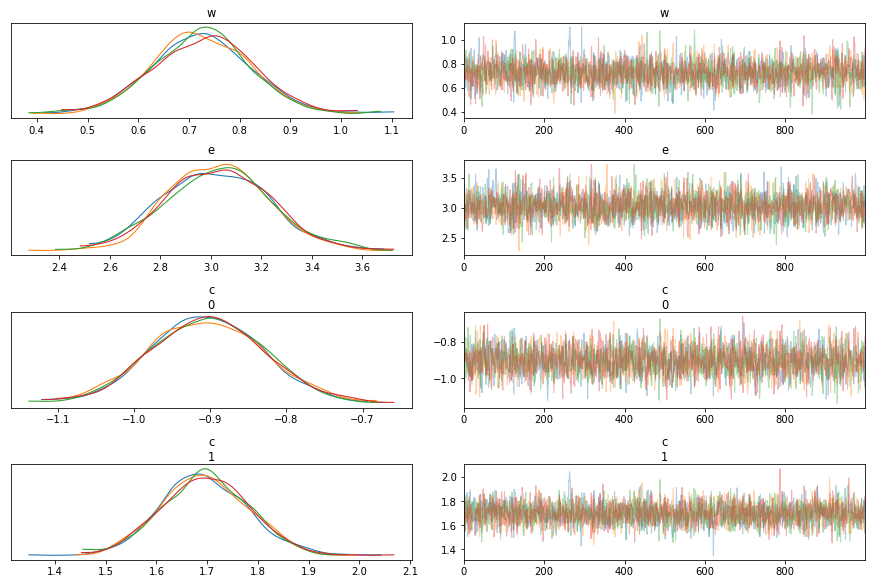

In [13]:
arviz.plot_trace(inference_data, var_names=["w", "e", "c"]);

In [14]:
train_cls_probs = get_class_probs(params, "ypred")
cls_pred = np.argmax(train_cls_probs, 1) + 1
print_results(train, cls_pred, "Train", dp=4)

Train - exact: 0.5495, out by one: 0.4440, out by two: 0.0065


In [15]:
test_cls_probs = get_class_probs(params, "ypred_test")
cls_pred_test = np.argmax(test_cls_probs, 1) + 1
print_results(test, cls_pred_test, "Test", dp=4)

Test - exact: 0.5497, out by one: 0.4411, out by two: 0.0092


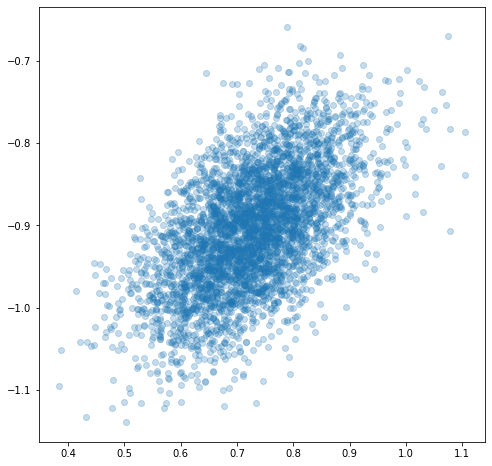

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(params["w"], params["c"][:, 0], alpha=0.25);

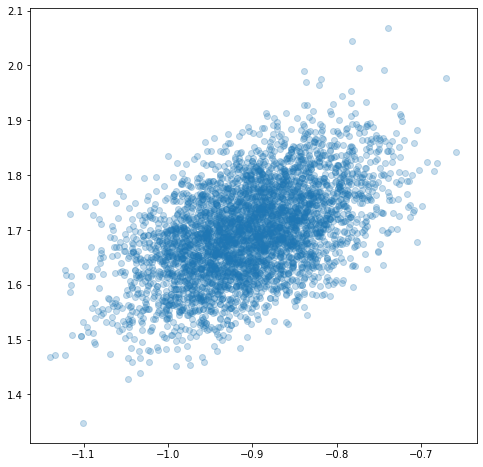

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter( params["c"][:, 0], params["c"][:, 1], alpha=0.25);

### Symmetric

In [19]:
params_sym = fit_sym.extract(permuted=True)

inference_data_sym = arviz.convert_to_inference_data(fit_sym)
summary_df_sym = (
    arviz.summary(inference_data_sym)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

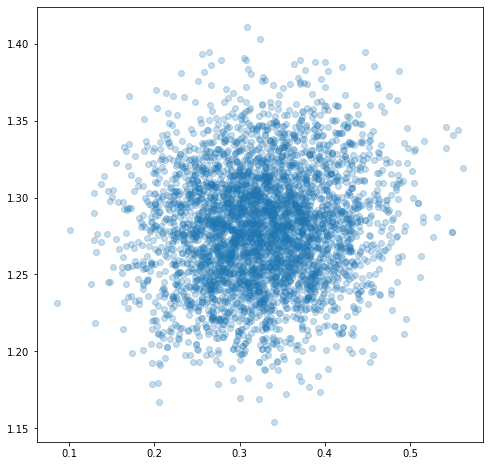

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(params_sym["w"], params_sym["c_raw"], alpha=0.25);

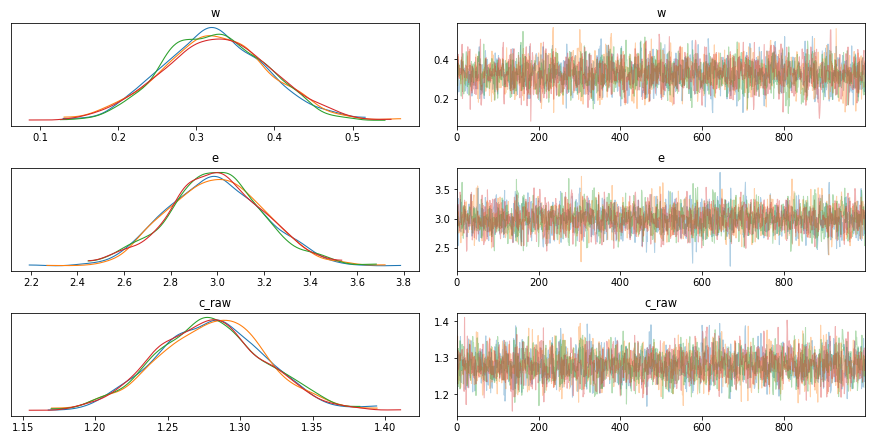

In [21]:
arviz.plot_trace(inference_data_sym, var_names=["w", "e", "c_raw"]);

In [22]:
train_cls_probs_sym = get_class_probs(params_sym, "ypred")
cls_pred_sym = np.argmax(train_cls_probs_sym, 1) + 1
print_results(train, cls_pred_sym, "Train", dp=4)

Train - exact: 0.5382, out by one: 0.4558, out by two: 0.0059


In [23]:
test_cls_probs_sym = get_class_probs(params_sym, "ypred_test")
cls_pred_test_sym = np.argmax(test_cls_probs_sym, 1) + 1
print_results(test, cls_pred_test_sym, "Test", dp=4)

Test - exact: 0.5681, out by one: 0.4296, out by two: 0.0023


### Comparison

For player 1 playing a player of the same elo rating:

\begin{align}
P_{\text{win}} &= \text{logit}^{-1}(w - c_1) \\
P_{\text{draw}} &= \text{logit}^{-1}(w - c_0) - \sigma^{-1}(w - c_1)\\
P_{\text{lose}} &= 1 - \text{logit}^{-1}(w - c_0)
\end{align}

In [24]:
def calculate_outcome_probs(params, elo_diff=0, verbose=True):
    inv_logit = lambda x: 1/(1 + np.exp(-x))
    w = params["w"].mean()
    e = params["e"].mean()
    c0 = params["c"][:, 0].mean()
    c1 = params["c"][:, 1].mean()

    prob_win = inv_logit(w - c1 + e*elo_diff)
    prob_draw = inv_logit(w - c0 + e*elo_diff) - inv_logit(w - c1 + e*elo_diff)
    prob_lose = 1 - inv_logit(w - c0 + e*elo_diff)
    if verbose:
        print(f"Prob - win: {prob_win:.4f}, draw: {prob_draw:.4f}, lose: {prob_lose:.4f}")
    return prob_win, prob_draw, prob_lose

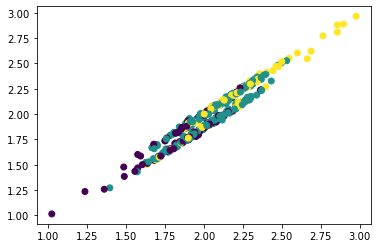

In [25]:
plt.scatter(params_sym["ypred_test"].mean(0), params["ypred_test"].mean(0), c=test["p1_outcome"].values);
#plt.legend();

In [27]:
_ = calculate_outcome_probs(params)

Prob - win: 0.2749, draw: 0.5613, lose: 0.1638


In [28]:
_ = calculate_outcome_probs(params_sym)

Prob - win: 0.2778, draw: 0.5548, lose: 0.1674


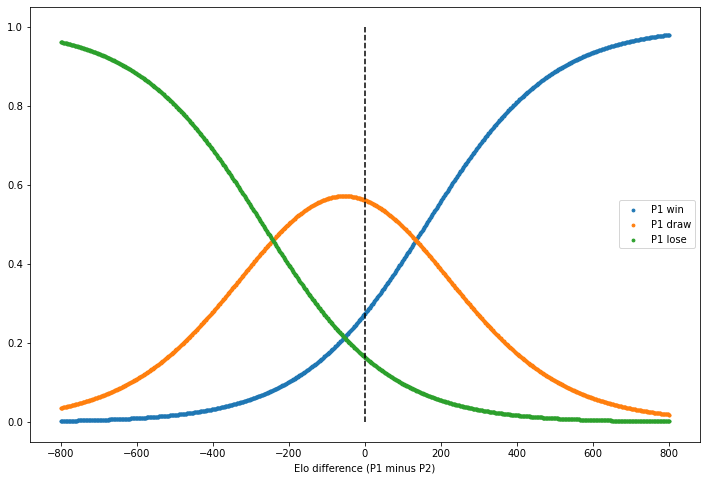

In [58]:
ed = np.linspace(-800, 800, 1000)

pw, pd, pl = calculate_outcome_probs(params, elo_diff=ed/500, verbose=False)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(ed, pw, s=8, label="P1 win");
ax.scatter(ed, pd, s=8, label="P1 draw");
ax.scatter(ed, pl, s=8, label="P1 lose");
ax.vlines(0, ymin=0, ymax=1, linestyle="--");
ax.legend();
ax.set_xlabel("Elo difference (P1 minus P2)");